# COVID Economics
## Hoang Viet Truong, Jad Alriyabi, Rui Yu, and Insoo Rhee

## Table of Contents
### A. Graph for COVID, Stock Price, and M2
### B. Histogram for Stock Returns
### C. Predicting Covid Cases and Stock Returns with graphs
### D. Calling Functions

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.dates

import math

import mpl_toolkits.axisartist as AA
from mpl_toolkits.axes_grid1 import host_subplot

from matplotlib.pylab import rcParams
import matplotlib.patches as mpatches
rcParams['figure.figsize']=20,10

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

In [3]:
data = pd.read_csv('covid-data.csv')
data = data[['location', 'Date', 'total_cases']]

data = data.astype({"total_cases": float})
data["Date"] = pd.to_datetime(data.Date, format="%Y-%m-%d")
data.head()

,location,Date,total_cases
0,Afghanistan,2020-02-24,1.0
1,Afghanistan,2020-02-25,1.0
2,Afghanistan,2020-02-26,1.0
3,Afghanistan,2020-02-27,1.0
4,Afghanistan,2020-02-28,1.0


# A. Graph for COVID, Stock Price, and M2

In [4]:
def graph(country):

    ##Covid cases
    df = data.loc[data.location == country]

    host = host_subplot(111, axes_class=AA.Axes)

    host.set_xlabel("Date")
    host.set_ylabel("COVID Cases")
    host.set_title(country + ' (COVID, Stock Return, and M2)')

    host.plot(df.Date, df.total_cases, 'r')
    host.axis["left"].label.set_color('r')

    one = mpatches.Patch(facecolor='red', label='COVID Cases', linewidth = 0.5, edgecolor = 'black')
    two = mpatches.Patch(facecolor='green', label = 'Stock Index', linewidth = 0.5, edgecolor = 'black')
    three = mpatches.Patch(facecolor='blue', label = 'M2 (money supply)', linewidth = 0.5, edgecolor = 'black')

    legend = plt.legend(handles=[one, two, three], loc = 4, fontsize = 'small', fancybox = True)
    
    frame = legend.get_frame()
    frame.set_facecolor('#b4aeae')
    frame.set_edgecolor('black')
    frame.set_alpha(1) #deals with transparency

    ##Stock Index
    stockFile = country + ' Historical Data.csv'
    sr = pd.read_csv(stockFile)

    sr = sr.replace({',':''}, regex = True)
    sr = sr.astype({"Close": float})
    sr["Date"] = pd.to_datetime(sr.Date, format="%Y-%m-%d") 
    
    par = host.twinx()

    new_fixed_axis = par.get_grid_helper().new_fixed_axis
    par.axis["right"] = new_fixed_axis(loc="right", axes=par)

    par.set_ylim(0.5*np.min(sr.Close, axis=0)-1, 1.5*np.max(sr.Close, axis=0))
    par.set_ylabel("Stock Index")

    par.plot(sr.Date, sr.Close,'g--')
    par.axis["right"].label.set_color('g')
    
    ##M2
    M2File = country + '_m2.csv'
    m2 = pd.read_csv(M2File)

    m2 = m2.replace({',':''}, regex = True)
    m2 = m2.astype({"m2": float})
    m2["Date"] = pd.to_datetime(m2.Date, format="%Y-%m-%d") 
    
    par2 = host.twinx()
    new_fixed_axis2 = par2.get_grid_helper().new_fixed_axis

    par2.axis["right"] = new_fixed_axis2(loc="right",axes=par2,offset=(60, 0))
    par2.axis["right"].toggle(all=True)

    par2.set_ylim(0.5*np.min(m2.m2, axis=0)-1, 1.5*np.max(m2.m2, axis=0))
    
    ylabel = "M2 (money supply)"
    if(m2.unit[0] != 'none'):
        ylabel += "(" + m2.unit[0] + ")"
    
    par2.set_ylabel(ylabel)

    par2.plot(m2.Date, m2.m2, 'b')
    par2.axis["right"].label.set_color('b')
    
    ##Merge and Correlation for Stock Return and M2
    pd_merge = pd.merge(left=sr, left_on='Date', right=m2, right_on='Date')

    cor = round(pd_merge.m2.corr(pd_merge.Close),2)

    print("correlation(Stock Index, M2) for "+ country +" is" , cor)

# B. Histogram for Stock Returns

In [5]:
def histogram(country):

    ##Histogram Bins
    stockFile = country + ' Historical Data.csv'
    sr = pd.read_csv(stockFile)
    
    sr = sr.replace({'%':''}, regex = True)
    sr = sr.astype({"change": float})
    sr["Date"] = pd.to_datetime(sr.Date, format="%Y-%m-%d")
    
    print("**" + country + "** Statistical analysis on Stock Price daily changes.")
    print("The data's range starts from", sr.Date.min(), "to",sr.Date.max())
    print("The mean of daily change is" , round(sr.change.mean(),3) , "The median is", round(sr.change.median(),3))
    print("The standard deviation is", round(sr.change.std(),2),"The skewness is", round(sr.change.skew(),2))
    
    sort_dates = sr.sort_values(by=['change'], ascending=False)

    numShowing = 5
    print("Sorted", numShowing, " of Maximum change in price")
    print(sort_dates[['Date', 'change']].reset_index().head(numShowing))
    print("Sorted", numShowing, " of Minimum change in price")
    print(sort_dates[['Date', 'change']].reset_index().tail(numShowing))

    plt.hist(sr.change, 20, density=False, histtype='bar', facecolor='r', alpha=1)
    plt.xlabel('Stock Returns in %')
    plt.ylabel('Number of Frequency')
    plt.title(country + ' Histogram of Stock Returns in %')
    plt.show()

# C. Predicting Covid Cases and Stock Returns with graphs

In [6]:
def loadStockData(country, min_max_scaler):
    
    fileName = country + ' Historical Data.csv'
    df = pd.read_csv(fileName)
    df = df[['Date','Close']]

    df = df.replace({',':''}, regex = True)
    df = df.astype({"Close": float})
    df['Date'] = pd.to_datetime(df.Date, format="%Y-%m-%d")
    df.index = df['Date']

    dataset = min_max_scaler.fit_transform(df['Close'].values.reshape(-1, 1))

    return df, dataset, min_max_scaler

def loadCovidData(country, min_max_scaler):

    df = data.loc[data.location == country]
    df = df[['Date','total_cases']]

    dataset = min_max_scaler.fit_transform(df['total_cases'].values.reshape(-1, 1))

    return df, dataset, min_max_scaler

In [7]:
def create_dataset(dataset, look_back):

    dataX, dataY = [], []

    for i in range(len(dataset)-look_back+1):
        dataX.append(dataset[i:(i+look_back), 0])
        dataY.append(dataset[i+look_back-1, 0])

    return np.array(dataX), np.array(dataY)

In [8]:
def preprocessData(df, dataset, look_back):

    #Using 80% of the data to train and 20% to test
    train_size = int(len(dataset) * 0.8)
    test_size = len(dataset) - train_size
    #Test data makes use of some train data as look back observations to predict
    train, test = dataset[0:train_size,:], dataset[-(test_size+look_back-1):,:]
    trainDates, testDates = df.Date[0:train_size], df.Date[-test_size:]

    x_train, y_train = create_dataset(train, look_back)
    x_test, y_test = create_dataset(test, look_back)

    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

    return x_train, y_train, x_test

In [9]:
def createCovidModel(x_train, y_train, look_back):

    model = Sequential()

    model.add(LSTM(units=50, return_sequences=True, input_shape=(1, look_back)))
    model.add(Dropout(0.2))

    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=25, batch_size=15, verbose=2)

    return model

def createStockModel(x_train, y_train, look_back):
    model = Sequential()

    model.add(LSTM(units=50, input_shape=(1, look_back)))

    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=25, batch_size=15, verbose=2)

    return model

In [10]:
def predict_dates(df,num_prediction):

    last_date = df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    prediction_dates = pd.to_datetime(prediction_dates, format="%Y-%m-%d")
    prediction_dates = prediction_dates[1:]
    return prediction_dates.values

def predict(num_prediction, model, dataset, look_back, min_max_scaler):

    dataset = dataset.reshape((-1))
    prediction_list = dataset[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, 1, look_back))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    
    prediction_list = prediction_list[look_back-1:]
    prediction_list = prediction_list.reshape((num_prediction+1,1))
    prediction_list = min_max_scaler.inverse_transform(prediction_list)
    
    return prediction_list

In [11]:
def predictionGraph(country, covidDataset, testCovidPredict, covid_forecast, covidDates, stockDataset, testStockPredict, stock_forecast, stockDates):
    
    host = host_subplot(111, axes_class=AA.Axes)

    par = host.twinx()

    new_fixed_axis = par.get_grid_helper().new_fixed_axis
    par.axis["right"] = new_fixed_axis(loc="right", axes=par)
    par.set_ylim(0.5*np.min(stockDataset, axis=0) - 1, 1.5*np.max(stockDataset, axis=0))

    host.plot(covidDates[:(-len(covid_forecast)+1)],covidDataset,'black', label = 'COVID Data')
    host.plot(covidDates[(len(covidDataset)-len(testCovidPredict)):len(covidDataset)],testCovidPredict,'g',linewidth = 2, label = 'COVID Test')
    host.plot(covidDates[-len(covid_forecast):],covid_forecast,'r',label = 'COVID Predict')

    par.plot(stockDates[:(-len(stock_forecast)+1)],stockDataset,'b', label = 'Stock Data')
    par.plot(stockDates[(len(stockDataset)-len(testStockPredict)):len(stockDataset)],testStockPredict,'--g',linewidth = 2, label = 'Stock Test')
    par.plot(stockDates[-len(stock_forecast):],stock_forecast,'--r',label = 'Stock Predict')

    host.legend()

    plt.title("COVID cases, Stock Return Predictions of " + country)
    host.axis["left"].label.set_color('black')
    par.axis["right"].label.set_color('b')

    host.set_xlabel("Date")
    host.set_ylabel("COVID Cases")
    par.set_ylabel("Stock Return")

    plt.show()

In [12]:
def performMachineLearning(country):
    
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

    covid_df, covidDataset, covid_min_max_scaler = loadCovidData(country, min_max_scaler)
    stock_df, stockDataset, stock_min_max_scaler = loadStockData(country, min_max_scaler)

    look_back = 15

    x_train_covid, y_train_covid, x_test_covid = preprocessData(covid_df, covidDataset, look_back)
    x_train_stock, y_train_stock, x_test_stock = preprocessData(stock_df, stockDataset, look_back)

    covidModel = createCovidModel(x_train_covid, y_train_covid, look_back)
    stockModel = createStockModel(x_train_stock, y_train_stock, look_back)

    #Performing predictions
    testCovidPredict = covidModel.predict(x_test_covid)
    testCovidPredict = testCovidPredict.reshape((len(testCovidPredict),1))
    testCovidPredict = covid_min_max_scaler.inverse_transform(testCovidPredict)

    testStockPredict = stockModel.predict(x_test_stock)
    testStockPredict = testStockPredict.reshape((len(testStockPredict),1))
    testStockPredict = stock_min_max_scaler.inverse_transform(testStockPredict)

    #Forecasting future data
    num_prediction = 30

    covid_forecast = predict(num_prediction, covidModel, covidDataset, look_back, covid_min_max_scaler)

    covidDatesPredicted = predict_dates(covid_df,num_prediction)
    covidDates = covid_df.Date.values.reshape((-1,1))
    covidDates = np.append(covidDates,covidDatesPredicted)


    stock_forecast = predict(num_prediction, stockModel, stockDataset, look_back, stock_min_max_scaler)

    stockDatesPredicted = predict_dates(stock_df,num_prediction)
    stockDates = stock_df.Date.values.reshape((-1,1))
    stockDates = np.append(stockDates,stockDatesPredicted)

    # plot baseline and predictions
    covidDataset = covid_min_max_scaler.inverse_transform(covidDataset)
    stockDataset = stock_min_max_scaler.inverse_transform(stockDataset)

    predictionGraph(country, covidDataset, testCovidPredict, covid_forecast, covidDates, stockDataset, testStockPredict, stock_forecast, stockDates)

# COVID Economics
## Hoang Viet Truong, Jad Alriyabi, Rui Yu, and Insoo Rhee

## Table of Contents
### A. Graph for COVID, Stock Price, and M2
### B. Histogram for Stock Returns
### C. Predicting Covid Cases and Stock Returns with graphs
### D. Calling Functions

# D. Calling Functions
### List of Countries
#### 0. Canada
#### 1. China
#### 2. France 
#### 3. Japan
#### 4. South Korea 
#### 5. United Arab Emirates
#### 6. United Kingdom
#### 7. United States

In [13]:
countryList = ["Canada", "China", "France", "Japan", "South Korea", "United Arab Emirates", "United Kingdom", "United States"]
country_US = countryList[7]

correlation(Stock Index, M2) for United States is 0.96


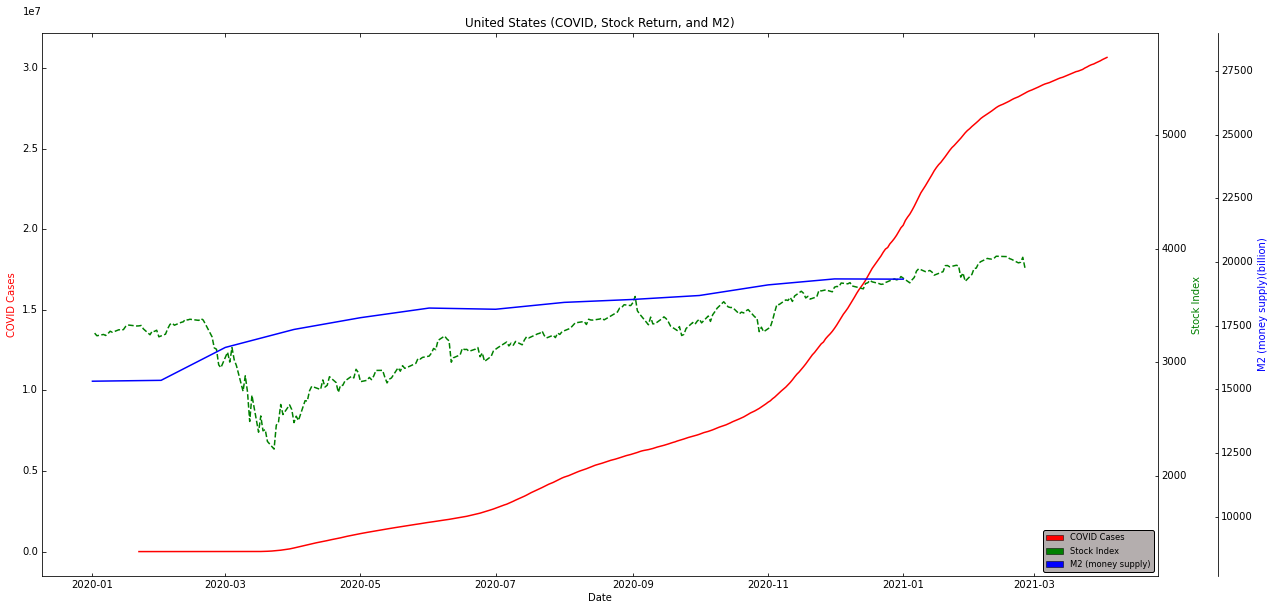

In [14]:
graph(country_US)

**United States** Statistical analysis on Stock Price daily changes.
The data's range starts from 2020-01-02 00:00:00 to 2021-02-25 00:00:00
The mean of daily change is 0.08 The median is 0.21
The standard deviation is 2.06 The skewness is -0.57
Sorted 5  of Maximum change in price
   index       Date  change
0     56 2020-03-24    9.38
1     49 2020-03-13    9.29
2     65 2020-04-06    7.03
3     58 2020-03-26    6.24
4     51 2020-03-17    6.00
Sorted 5  of Minimum change in price
     index       Date  change
285     52 2020-03-18   -5.18
286    111 2020-06-11   -5.89
287     45 2020-03-09   -7.60
288     48 2020-03-12   -9.51
289     50 2020-03-16  -11.98


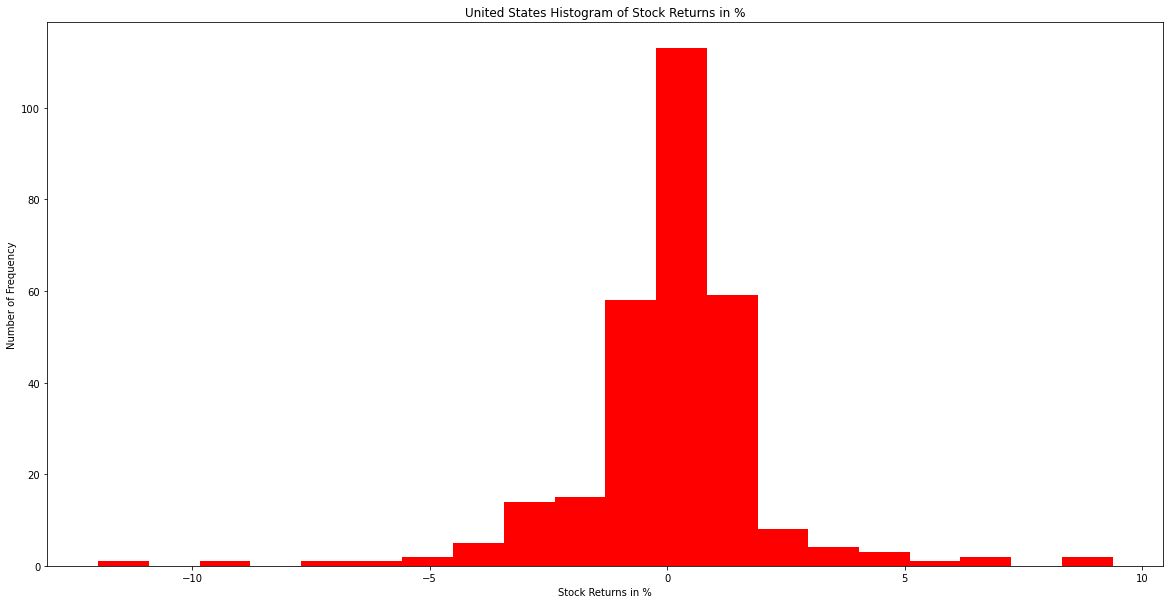

In [15]:
histogram(country_US)

Epoch 1/25
23/23 - 0s - loss: 0.0199
Epoch 2/25
23/23 - 0s - loss: 0.0021
Epoch 3/25
23/23 - 0s - loss: 0.0013
Epoch 4/25
23/23 - 0s - loss: 9.5692e-04
Epoch 5/25
23/23 - 0s - loss: 5.5545e-04
Epoch 6/25
23/23 - 0s - loss: 6.8185e-04
Epoch 7/25
23/23 - 0s - loss: 6.6974e-04
Epoch 8/25
23/23 - 0s - loss: 4.7553e-04
Epoch 9/25
23/23 - 0s - loss: 5.9258e-04
Epoch 10/25
23/23 - 0s - loss: 7.9321e-04
Epoch 11/25
23/23 - 0s - loss: 4.2130e-04
Epoch 12/25
23/23 - 0s - loss: 6.2292e-04
Epoch 13/25
23/23 - 0s - loss: 4.7997e-04
Epoch 14/25
23/23 - 0s - loss: 4.9291e-04
Epoch 15/25
23/23 - 0s - loss: 5.9003e-04
Epoch 16/25
23/23 - 0s - loss: 4.3934e-04
Epoch 17/25
23/23 - 0s - loss: 5.4580e-04
Epoch 18/25
23/23 - 0s - loss: 4.6447e-04
Epoch 19/25
23/23 - 0s - loss: 4.1654e-04
Epoch 20/25
23/23 - 0s - loss: 4.2326e-04
Epoch 21/25
23/23 - 0s - loss: 4.2457e-04
Epoch 22/25
23/23 - 0s - loss: 4.1384e-04
Epoch 23/25
23/23 - 0s - loss: 4.1476e-04
Epoch 24/25
23/23 - 0s - loss: 3.2988e-04
Epoch 25/25
2

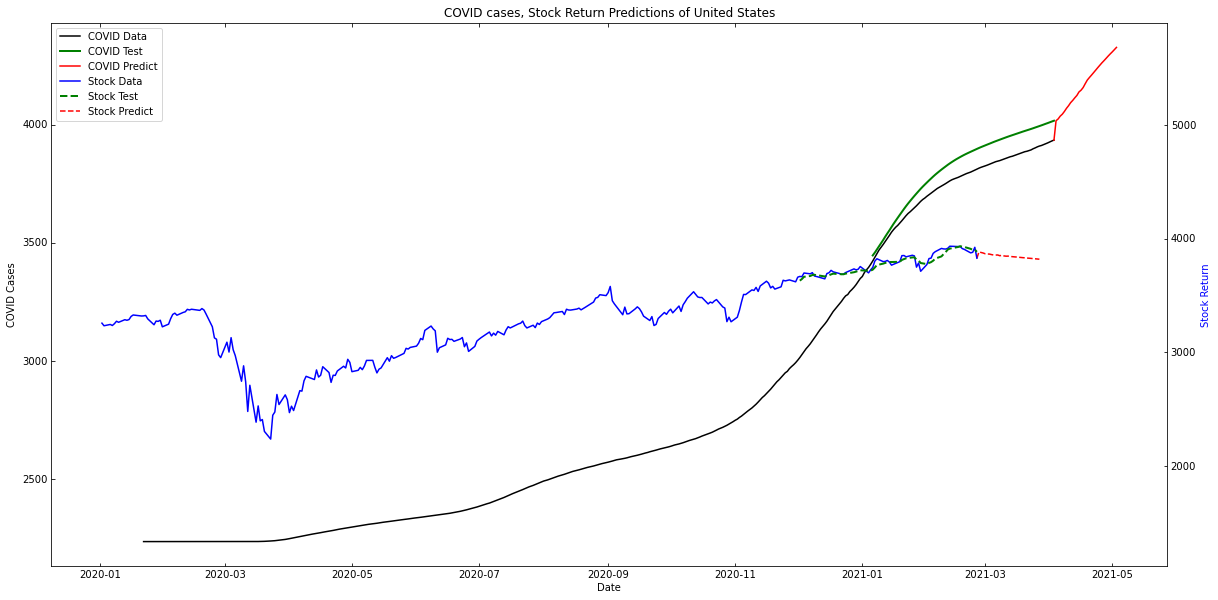

In [16]:
performMachineLearning(country_US)

correlation(Stock Index, M2) for Canada is 0.98


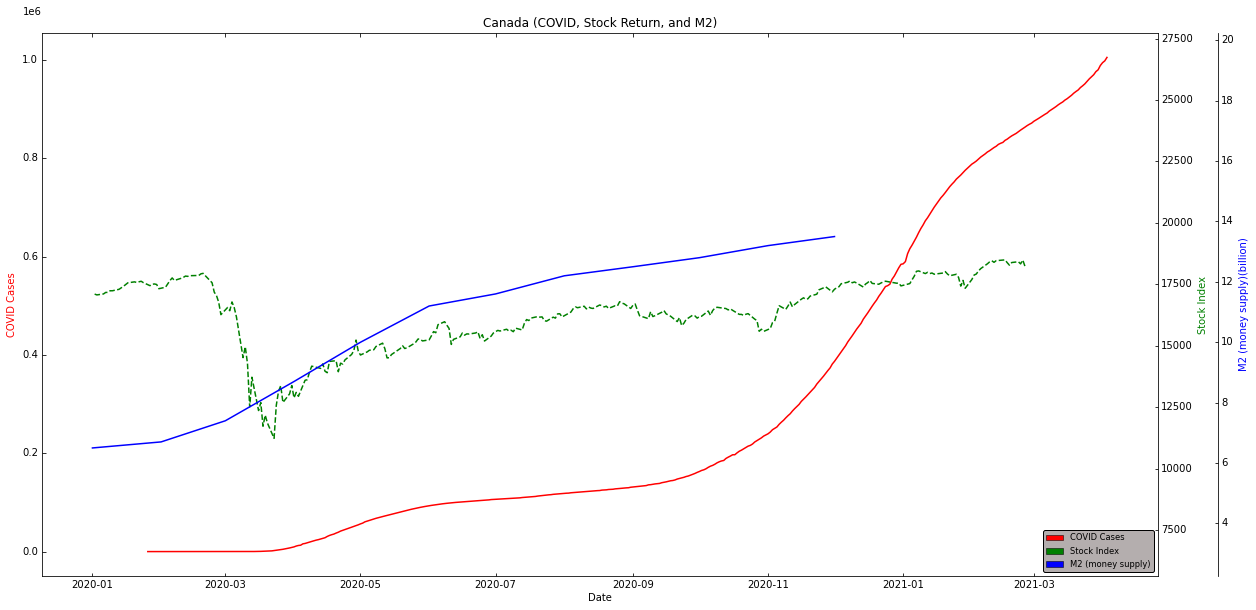

In [17]:
country_CA = countryList[0]
graph(country_CA)

**Canada** Statistical analysis on Stock Price daily changes.
The data's range starts from 2020-01-02 00:00:00 to 2021-02-25 00:00:00
The mean of daily change is 0.042 The median is 0.21
The standard deviation is 1.96 The skewness is -0.95
Sorted 5  of Maximum change in price
   index       Date  change
0     57 2020-03-24   11.96
1     50 2020-03-13    9.66
2     66 2020-04-06    5.06
3     58 2020-03-25    4.52
4     54 2020-03-19    3.83
Sorted 5  of Minimum change in price
     index       Date  change
285     56 2020-03-23   -5.26
286     53 2020-03-18   -7.60
287     51 2020-03-16   -9.89
288     46 2020-03-09  -10.27
289     49 2020-03-12  -12.34


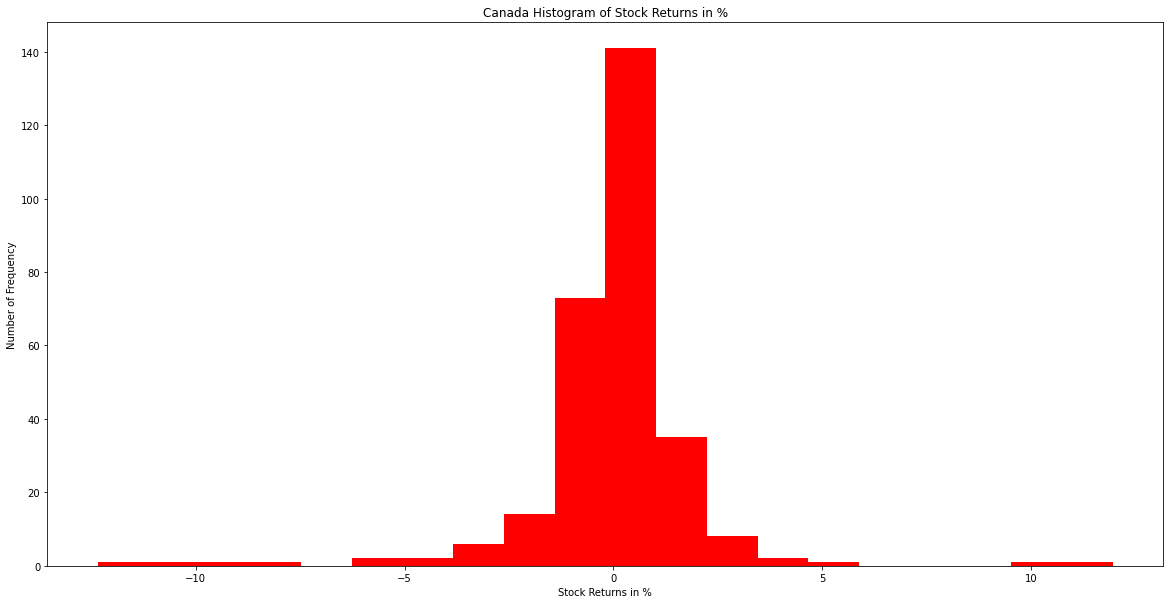

In [18]:
histogram(country_CA)

Epoch 1/25
23/23 - 0s - loss: 0.0123
Epoch 2/25
23/23 - 0s - loss: 0.0019
Epoch 3/25
23/23 - 0s - loss: 9.7369e-04
Epoch 4/25
23/23 - 0s - loss: 5.0079e-04
Epoch 5/25
23/23 - 0s - loss: 5.5679e-04
Epoch 6/25
23/23 - 0s - loss: 5.3143e-04
Epoch 7/25
23/23 - 0s - loss: 5.1770e-04
Epoch 8/25
23/23 - 0s - loss: 4.3638e-04
Epoch 9/25
23/23 - 0s - loss: 3.4834e-04
Epoch 10/25
23/23 - 0s - loss: 5.1881e-04
Epoch 11/25
23/23 - 0s - loss: 3.7018e-04
Epoch 12/25
23/23 - 0s - loss: 5.0886e-04
Epoch 13/25
23/23 - 0s - loss: 4.0699e-04
Epoch 14/25
23/23 - 0s - loss: 3.6198e-04
Epoch 15/25
23/23 - 0s - loss: 4.3199e-04
Epoch 16/25
23/23 - 0s - loss: 4.5119e-04
Epoch 17/25
23/23 - 0s - loss: 2.6790e-04
Epoch 18/25
23/23 - 0s - loss: 3.8629e-04
Epoch 19/25
23/23 - 0s - loss: 3.9127e-04
Epoch 20/25
23/23 - 0s - loss: 3.2704e-04
Epoch 21/25
23/23 - 0s - loss: 3.0140e-04
Epoch 22/25
23/23 - 0s - loss: 4.4520e-04
Epoch 23/25
23/23 - 0s - loss: 5.0806e-04
Epoch 24/25
23/23 - 0s - loss: 2.9450e-04
Epoch 25/

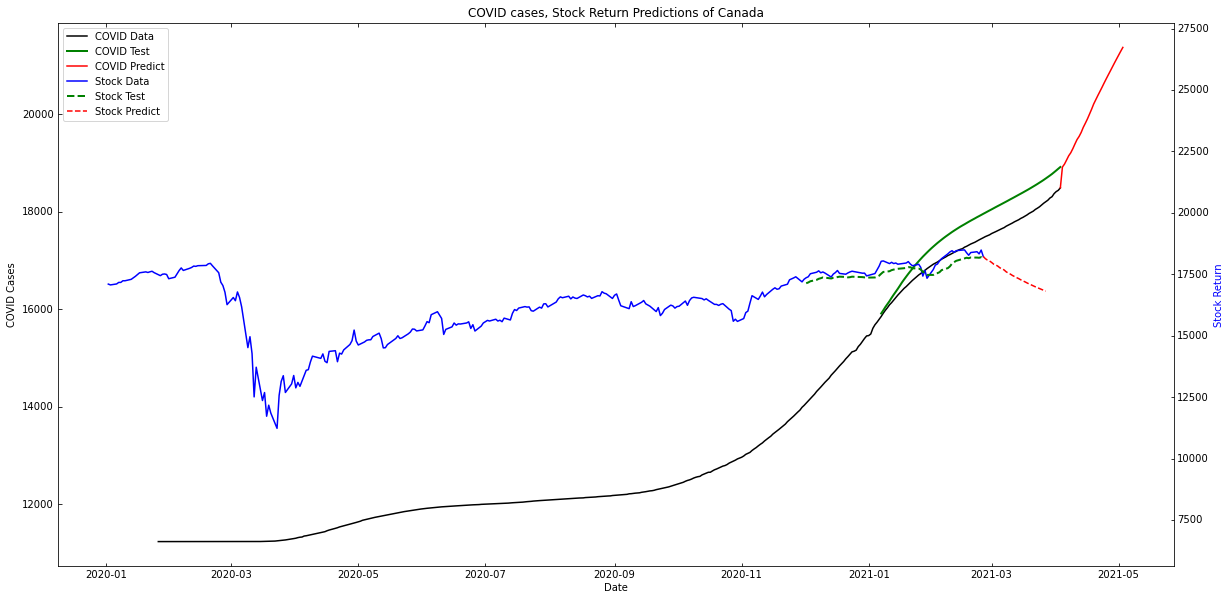

In [19]:
performMachineLearning(country_CA)

correlation(Stock Index, M2) for Japan is 0.52


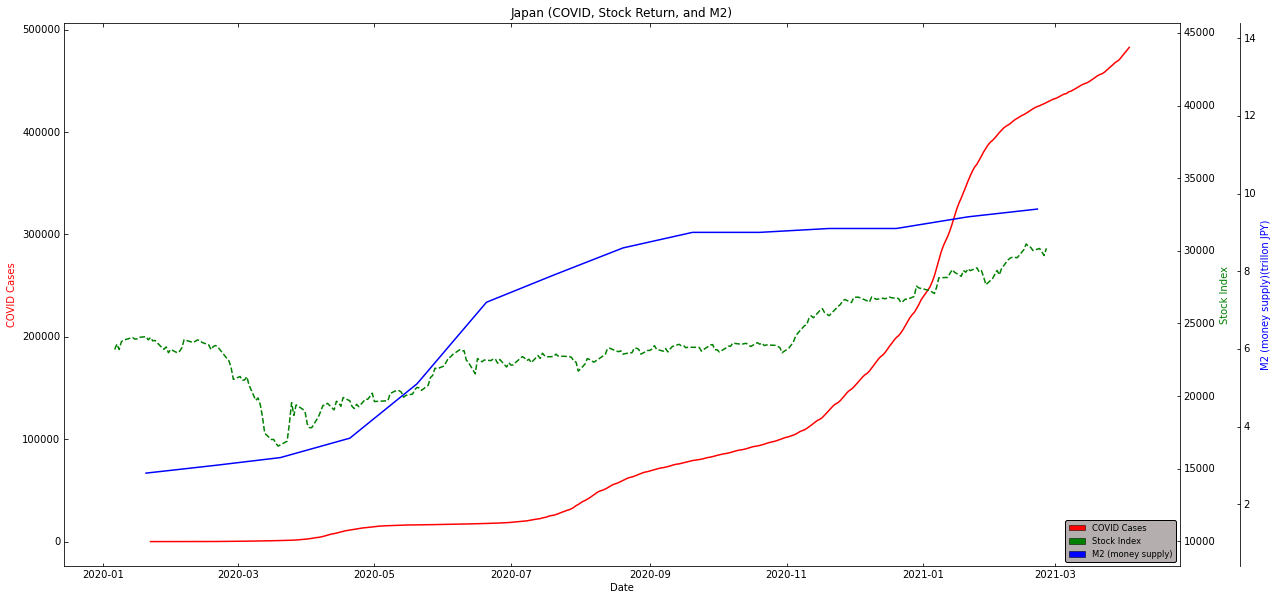

In [20]:
country_Japan = countryList[3]
graph(country_Japan)

**Japan** Statistical analysis on Stock Price daily changes.
The data's range starts from 2020-01-06 00:00:00 to 2021-02-25 00:00:00
The mean of daily change is 0.099 The median is 0.05
The standard deviation is 1.58 The skewness is 0.31
Sorted 5  of Maximum change in price
   index       Date  change
0     53 2020-03-25    8.04
1     52 2020-03-24    7.13
2    108 2020-06-16    4.88
3     61 2020-04-06    4.24
4     55 2020-03-27    3.88
Sorted 5  of Minimum change in price
     index       Date  change
274     45 2020-03-12   -4.41
275     58 2020-04-01   -4.50
276     54 2020-03-26   -4.51
277     42 2020-03-09   -5.07
278     46 2020-03-13   -6.08


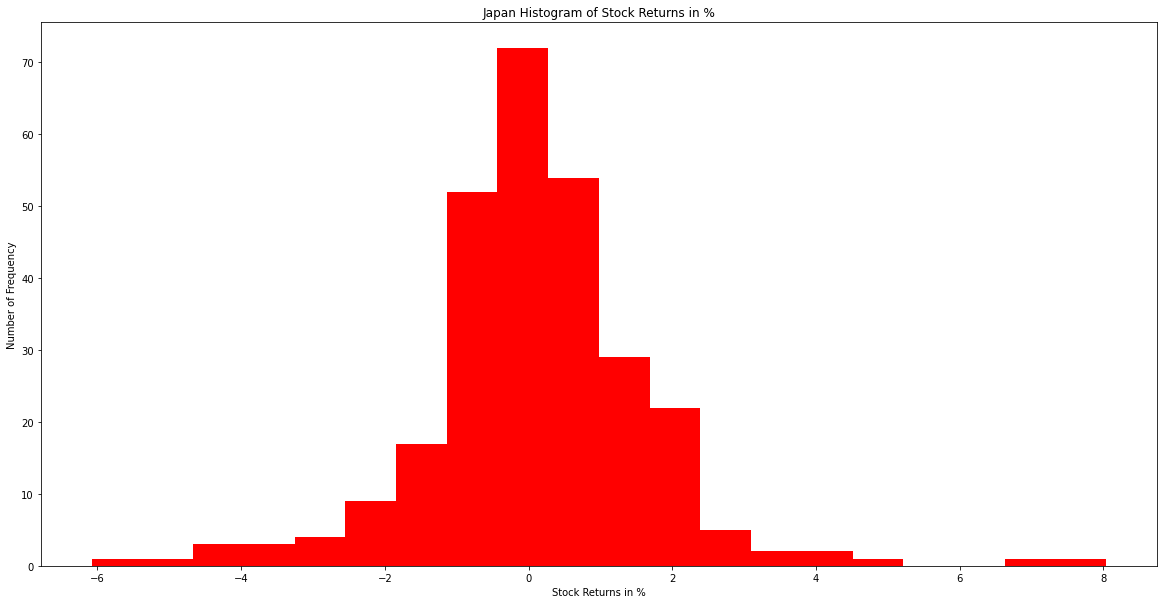

In [21]:
histogram(country_Japan)

Epoch 1/25
23/23 - 0s - loss: 0.0148
Epoch 2/25
23/23 - 0s - loss: 0.0026
Epoch 3/25
23/23 - 0s - loss: 8.3766e-04
Epoch 4/25
23/23 - 0s - loss: 6.6854e-04
Epoch 5/25
23/23 - 0s - loss: 6.0130e-04
Epoch 6/25
23/23 - 0s - loss: 4.0145e-04
Epoch 7/25
23/23 - 0s - loss: 3.8065e-04
Epoch 8/25
23/23 - 0s - loss: 3.9589e-04
Epoch 9/25
23/23 - 0s - loss: 4.4139e-04
Epoch 10/25
23/23 - 0s - loss: 4.2513e-04
Epoch 11/25
23/23 - 0s - loss: 4.2659e-04
Epoch 12/25
23/23 - 0s - loss: 4.1646e-04
Epoch 13/25
23/23 - 0s - loss: 3.4974e-04
Epoch 14/25
23/23 - 0s - loss: 3.2970e-04
Epoch 15/25
23/23 - 0s - loss: 4.0712e-04
Epoch 16/25
23/23 - 0s - loss: 2.3905e-04
Epoch 17/25
23/23 - 0s - loss: 3.7648e-04
Epoch 18/25
23/23 - 0s - loss: 3.0331e-04
Epoch 19/25
23/23 - 0s - loss: 2.6913e-04
Epoch 20/25
23/23 - 0s - loss: 3.2032e-04
Epoch 21/25
23/23 - 0s - loss: 2.7051e-04
Epoch 22/25
23/23 - 0s - loss: 2.8477e-04
Epoch 23/25
23/23 - 0s - loss: 2.6312e-04
Epoch 24/25
23/23 - 0s - loss: 2.3176e-04
Epoch 25/

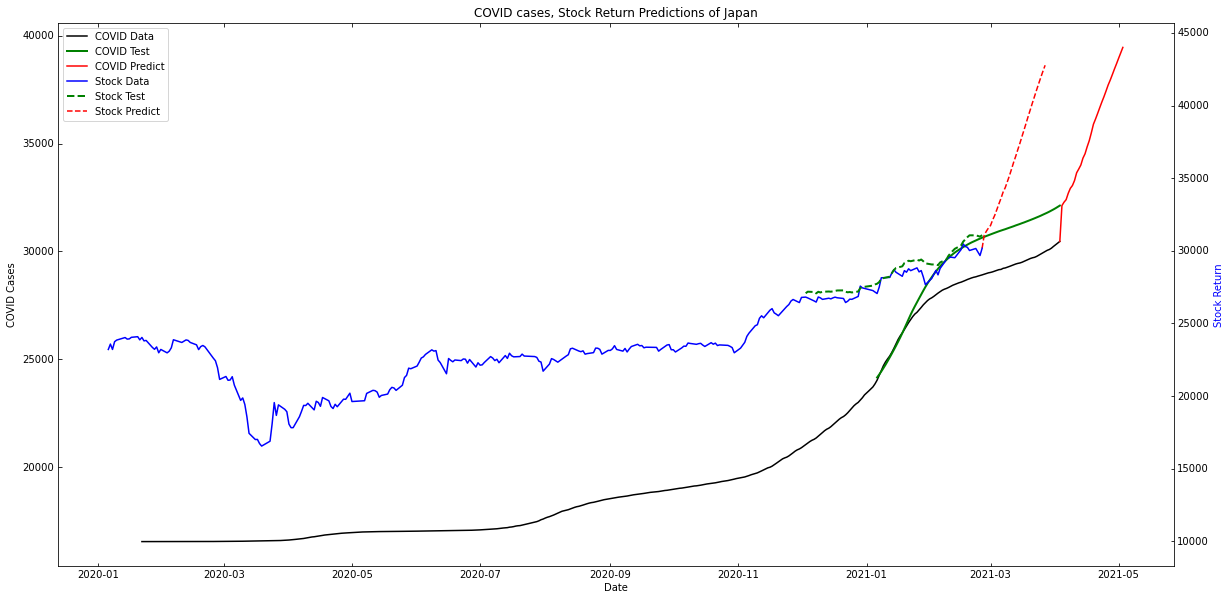

In [22]:
performMachineLearning(country_Japan)